# CALCULATION OF FREQUENCY GRID FOR RV PERIODOGRAM

This notebook calculates the desirable frequency grid for periodogram calculations, based on the characteristics of the RV time series. We also do some basic Nyquist calculations.

**Calculation details:**

For the establishment of the frequency grid for periodogram calculation, we need to define three values: the minimum frequency, the maximum frequency, and the frequency grid spacing, as per the recommendations on section 7.1 of _Understanding the Lomb–Scargle Periodogram (VanderPlas, J. T. 2018, APJS, 236(1), 16)_. In this work, the recommendations are the following ones:

- For the lower frequency limit, set it to 0, it would not do any difference in terms of computation load.
- For the upper frequency limit, set it to the Nyquist (uniform sampling) or pseudo-Nyquist (non-uniform sampling) or, even better, according to the specific scientific case (i.e. set it according to the periods we are searching for in the signals). 
- For the frequency grid spacing, use the inverse of the observation window, applying an additional factor between 1/5 and 1/10.

The stars currently under analysis are in the $He_{3}$ instability band, so they are expected to have effective temperatures in the range $T_{eff}\in[3300, 4300]\;K$, $\log g\in[4.5, 5.1]$, and masses in the range $M_{star}\in[0.20, 0.60]\;M_{\odot}$.

According to _Table 2_ in _The theoretical instability strip of M dwarf stars (Rodríguez-López, C., et al. 2014, MNRAS, 438, 2371)_ these stars have typical periods of $20\;min$ to $4\;h$ ($3\;h$?), so we could set the limits of the periodogram frequencies for periods between $5\;min$ and $10\;h$, so as to perfectly cover the target range and to leave enough margins if the stacked periodogram is to show some "plateau". In days, this corresponds to a range of $P\in[0.003472,\;0.416667]\;d$ or, equivalently, frequencies in the range $f\in[288.0,\;2.4]\;d^{-1}$.

For the grid spacing, we need to cover all the observation windows present in the objects under study, as they will all be different. We will hence calculate it looking into each of the source RV files. For easier calculation, we consider just the overall observation time of objects, instead of the length of multiple different observation periods that exist in each object. In any case, the value used will be a maximum possible observation time, yielding the smallest possible grip spacing (i.e. more resolution). As with this approach we are providing some additional margin for frequency resolution, we will use the value 1/5 for the factor.


## Modules and configuration

### Modules

In [1]:
# Modules import:
import numpy as np
import pandas as pd

#from scipy import stats

from matplotlib import pyplot as plt
from matplotlib import lines
import seaborn as sns

sns.set_style("white", {'figure.figsize':(16,9)})

### Configuration

In [2]:
# Configuration:
# Files and folders (WARNING: THIS FOLDER STRUCTURE MUST EXIST PREVIOUSLY):
#GTO_FILE = "../data/CARM_VIS_objects_with_PG.csv" # NOTE: initially this should be a copy of the previous file.
GTO_FILE = "../data/SELECTION_for_PG_CARM_VIS_objects_with_PG.csv" # NOTE: initially this should be a copy of the previous file.

IMAGE_FOLDER = "./img/"

N0 = 5 # For the factor (1/N0 = 1/5, 1/10,...)


### Functions

In [3]:
def draw_scatter(data, x, y, hue=None, size=None, alpha=None,
                 href_lines=[], href_label="", href_color="darkred", href_style="dotted",
                 vref_lines=[], vref_label="", vref_color="darkblue", vref_style="--",
                 title_override=None, xlabel_override=None, ylabel_override=None,
                 fig_filename=None):
    '''Draws a scatter plot as per the data passed, setting the title'''
    sns.set_style("white", {'figure.figsize':(16,9)})
    ax = sns.scatterplot(data=data, x=x, y=y, hue=hue, size=size, alpha=alpha)
    handles=[]
    for i in range(0, len(href_lines)):
        if i == 0 and href_label is not None:
            handles.append(lines.Line2D([], [], color=href_color, linestyle=href_style, label=href_label))
        else:
            pass
        ax.axhline(y=href_lines[i], color=href_color, linestyle=href_style)
    for i in range(0, len(vref_lines)):
        if i == 0 and vref_label is not None:
            handles.append(lines.Line2D([], [], color=vref_color, linestyle=vref_style, label=vref_label))
        else:
            pass
        ax.axvline(x=vref_lines[i], color=vref_color, linestyle=vref_style)

    if title_override is None:
        title = "Correlation - " + x + " vs. " + y
    else:
        title = title_override
    if hue is not None:
        title = title + "\nBy " + hue + " (colour)"
    if size is not None:
        title = title + "\nBy " + size + " (size)"
    ax.set_title(title, fontsize='x-large')
    if xlabel_override is None:
        ax.set_xlabel(x, fontsize='large')
    else:
        ax.set_xlabel(xlabel_override, fontsize='large')
    if ylabel_override is None:
        ax.set_ylabel(y, fontsize='large')
    else:
        ax.set_ylabel(ylabel_override, fontsize='large')
    ax.figure.set_size_inches(16, 9)
    ax.legend(handles=handles, loc='upper right')
    
    if fig_filename == None:
        pass
    else:
        ax.figure.savefig(fig_filename, format='jpg')

## Data processing

### GTO data loading

In [4]:
# Load GTO data table:
gto = pd.read_csv(GTO_FILE, sep=',', decimal='.')
gto.head(5)

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,WF_offset_PG_TESS,WF_e_offset_PG_TESS,WF_FAP_PG_TESS,WF_valid_PG_TESS,WF_error_PG_TESS,WF_elapsed_time_PG_TESS,WF_plain_file_TESS,WF_fig_file_TESS,PG_file_RV,PG_file_TESS
0,J23548+385,RX J2354.8+3831,-,NaN,358.713658,38.526340,23:54:51.46,+38:31:36.2,110.941908,-23.024449,...,999.999756,2.151008e-06,1.0,1.0,NaN,94.758838,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23548+38...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23548+385_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23548+385_RV_PG.dat
1,J23505-095,LP 763-012,-,4367,357.634705,-9.560964,23:50:31.64,-09:33:32.7,80.777067,-67.303426,...,1000.000122,9.022946e-07,1.0,1.0,NaN,132.607176,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23505-09...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23505-095_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23505-095_RV_PG.dat
2,J23431+365,GJ 1289,-,1289,355.781509,36.536310,23:43:06.31,+36:32:13.1,107.922839,-24.336479,...,999.999512,4.306074e-06,1.0,1.0,NaN,97.939914,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23431+36...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23431+365_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23431+365_RV_PG.dat
3,J23381-162,G 273-093,-,4352,354.532687,-16.236514,23:38:08.16,-16:14:10.2,61.845437,-69.825220,...,1000.000122,9.022946e-07,1.0,1.0,NaN,136.603404,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23381-16...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23381-162_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23381-162_RV_PG.dat
4,J23245+578,BD+57 2735,-,895,351.126628,57.853057,23:24:30.51,+57:51:15.5,111.552287,-3.085183,...,999.999512,3.720858e-06,1.0,1.0,NaN,131.327304,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23245+57...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23245+578_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23245+578_RV_PG.dat


In [5]:
gto.shape

(269, 300)

In [6]:
print(list(gto.columns))

['Karmn', 'Name', 'Comp', 'GJ', 'RA_J2016_deg', 'DE_J2016_deg', 'RA_J2000', 'DE_J2000', 'l_J2016_deg', 'b_J2016_deg', 'Ref01', 'SpT', 'SpTnum', 'Ref02', 'Teff_K', 'eTeff_K', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'Ref03', 'L_Lsol', 'eL_Lsol', 'Ref04', 'R_Rsol', 'eR_Rsol', 'Ref05', 'M_Msol', 'eM_Msol', 'Ref06', 'muRA_masa-1', 'emuRA_masa-1', 'muDE_masa-1', 'emuDE_masa-1', 'Ref07', 'pi_mas', 'epi_mas', 'Ref08', 'd_pc', 'ed_pc', 'Ref09', 'Vr_kms-1', 'eVr_kms-1', 'Ref10', 'ruwe', 'Ref11', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1', 'W_kms-1', 'eW_kms-1', 'Ref12', 'sa_m/s/a', 'esa_m/s/a', 'Ref13', 'SKG', 'Ref14', 'SKG_lit', 'Ref14_lit', 'Pop', 'Ref15', 'vsini_flag', 'vsini_kms-1', 'evsini_kms-1', 'Ref16', 'P_d', 'eP_d', 'Ref17', 'pEWHalpha_A', 'epEWHalpha_A', 'Ref18', 'log(LHalpha/Lbol)', 'elog(LHalpha/Lbol)', 'Ref19', '1RXS', 'CRT_s-1', 'eCRT_s-1', 'HR1', 'eHR1', 'HR2', 'eHR2', 'Flux_X_E-13_ergcm-2s-1', 'eFlux_X_E-13_ergcm-2s-1', 'LX/LJ', 'eLX/LJ', 'Ref20', 'Activity', 'Ref21', 'FUV_mag',

### Calculate the main sampling parameters for each time series

In [7]:
sampling_df = pd.DataFrame(columns=['Karmn', 'T_obs',
                                    'median_delta_t', 'f_nyq_by_median',
                                    'min_delta_t', 'f_nyq_by_min',
                                    'valid_for_PG'],
                           dtype=float)
sampling_df

,Karmn,T_obs,median_delta_t,f_nyq_by_median,min_delta_t,f_nyq_by_min,valid_for_PG


In [8]:
for i in range(0, len(gto)):
    karmn = gto.loc[i, 'Karmn']
    # Read the RV file:
    rv = pd.read_csv(gto.loc[i, 'rv_file'], sep=' ', decimal='.', names=['time', 'rv', 'e_rv'])
    # Calculate the observation time:
    t_obs = rv.time.max() - rv.time.min()
    # Calculate the list of delta times:
    if len(rv.time) > 1:
        delta_t = rv.time[1:].reset_index(drop=True) - rv.time[:-1].reset_index(drop=True)
        median_deltat = np.nanmedian(delta_t)
        min_deltat = min(delta_t)
    else:
        # Less than two RV points are present in the series:
        median_deltat = np.nan
        min_deltat = np.nan
    # Populate a new row:
    # (Is this "pythonic"? Using "loc" for a row that is not there yet?)
    sampling_df.loc[i, 'Karmn'] = karmn
    sampling_df.loc[i, 'T_obs'] = t_obs
    sampling_df.loc[i, 'median_delta_t'] = median_deltat
    sampling_df.loc[i, 'min_delta_t'] = min_deltat
    sampling_df.loc[i, 'valid_for_PG'] = (gto.loc[i, 'valid_PG_RV'] == 1) & \
        (gto.loc[i, 'valid_PG_TESS'] == 1)


In [9]:
len(sampling_df)

269

In [10]:
sampling_df.head()

,Karmn,T_obs,median_delta_t,f_nyq_by_median,min_delta_t,f_nyq_by_min,valid_for_PG
0,J23548+385,169.695378,13.940021,NaN,2.026237,NaN,True
1,J23505-095,1581.691279,2.908164,NaN,0.893761,NaN,True
2,J23431+365,1887.849159,17.057200,NaN,0.933345,NaN,True
3,J23381-162,1188.804379,3.019729,NaN,0.889856,NaN,True
4,J23245+578,1693.189632,5.992043,NaN,0.764900,NaN,True


In [11]:
sum(sampling_df['valid_for_PG'] == True)

269

#### Calculate the Nyquist frequencies

According to sources (https://ui.adsabs.harvard.edu/abs/1999A%26AS..135....1E/abstract), there are several options to estimate a limiting Nyquist frequency for irregularly sampled data:

- $f_{N}=1/2\overline{\delta t}$, being $\overline{\delta t}$ the "average" sampling rate of the series.
- $f_{N}=1/2s$, being $s$ the smallest time interval in the series.
- A relatively complex calculation expressing the time of observations as $t_{i}=t_{1}+n_{i}p$, where $n_{i}\in\mathbb{N}$ and $p$ is the greatest common divisor (gcd) for all $(t_{i}-t_{1})$.

The first two bullets are easy to calculate, but the last one is not easy with such irregular sampling as the one present in CARMENES RV timer series.

Hence, we will just calculate the two first values, using the median value as the "average" value mentioned in the first bullet, so as to prevent the possible gaps in observations to greatly modify the value.

In [12]:
sampling_df['f_nyq_by_median'] = 1.0 / (2.0 * sampling_df['median_delta_t'])
sampling_df['f_nyq_by_min'] = 1.0 / (2.0 * sampling_df['min_delta_t'])

In [13]:
sampling_df.head()

,Karmn,T_obs,median_delta_t,f_nyq_by_median,min_delta_t,f_nyq_by_min,valid_for_PG
0,J23548+385,169.695378,13.940021,0.035868,2.026237,0.246763,True
1,J23505-095,1581.691279,2.908164,0.171930,0.893761,0.559434,True
2,J23431+365,1887.849159,17.057200,0.029313,0.933345,0.535707,True
3,J23381-162,1188.804379,3.019729,0.165578,0.889856,0.561889,True
4,J23245+578,1693.189632,5.992043,0.083444,0.764900,0.653680,True


In [14]:
sampling_df.dtypes

Karmn               object
T_obs              float64
median_delta_t     float64
f_nyq_by_median    float64
min_delta_t        float64
f_nyq_by_min       float64
valid_for_PG        object
dtype: object

### Calculate the maximum observation window length present in the data

In [15]:
max_T = sampling_df['T_obs'].max()
print("Max. RV observation time in days: %f" %max_T)

Max. RV observation time in days: 2290.764508


#### Statistics

In [16]:
sampling_df[['T_obs']].describe()

,T_obs
count,269.000000
mean,1168.042305
std,641.028263
min,51.899532
25%,661.980425
50%,1261.673990
75%,1639.684300
max,2290.764508


### Calculate the minimum frequency grid spacing

In [17]:
delta_f = 1.0 / (N0 * max_T)
print("Frequency grid spacing must be smaller than %f d^(-1)" %delta_f)

Frequency grid spacing must be smaller than 0.000087 d^(-1)


Hence, about a 0.00008 frequency grid spacing should do well:

In [18]:
n = int((288.0 - 2.4) / 0.00008)
print("Estimated number of points for each periodogram: %d" %n)

Estimated number of points for each periodogram: 3570000


This is $\approx3.6M$ points for each periodogram, which seems to be pretty high. Calculation will take time, probably.

### Check the Nyquist criteria 

#### Statistics

In [19]:
sampling_df.describe()

,T_obs,median_delta_t,f_nyq_by_median,min_delta_t,f_nyq_by_min
count,269.000000,269.000000,269.000000,269.000000,269.000000
mean,1168.042305,16.728466,0.722254,2.398259,16.880453
std,641.028263,32.342565,9.599716,5.648689,41.862830
min,51.899532,0.003176,0.001625,0.001809,0.011147
25%,661.980425,3.045991,0.027744,0.061030,0.250910
50%,1261.673990,8.935142,0.055959,0.948975,0.526884
75%,1639.684300,18.022019,0.164150,1.992744,8.192628
max,2290.764508,307.604864,157.453748,44.855254,276.378434


As we can see, for most of the objects (75%) the Nyquist frequency is below or very near the lower limit of the expected star pulsation range of $f_{Pulsation}\in[8.0,\;72.0]\;d^{-1}$, no matter which of the two formulas we decide to apply (median or minimum sampling interval, yielding values of $\approx0.16\;d^{-1}$ and $\approx8.19\;d^{-1}$, respectively). This means that for most of the objects we are expecting frequencies to be above their Nyquist frequency for unevenly sampled time series.

Also, 50% of the objects show a Nyquist frequency very well below the expected frequencies. For individual detection of pulsations this is really a problem, because we will have two false frequencies at $f_{Pulsation}\pm f_{Nyquist}$. However, in terms of stacked periodograms this should not be a problem, because the false detected frequencies will fall very near the real frequency, and hence won't be far from the range of expected frequencies. 

Hence, it is expected that periodogram analysis is not adecuate for this case, at least when individually applied to each of the objects.


#### Graphical representation of Nyquist frequency limits

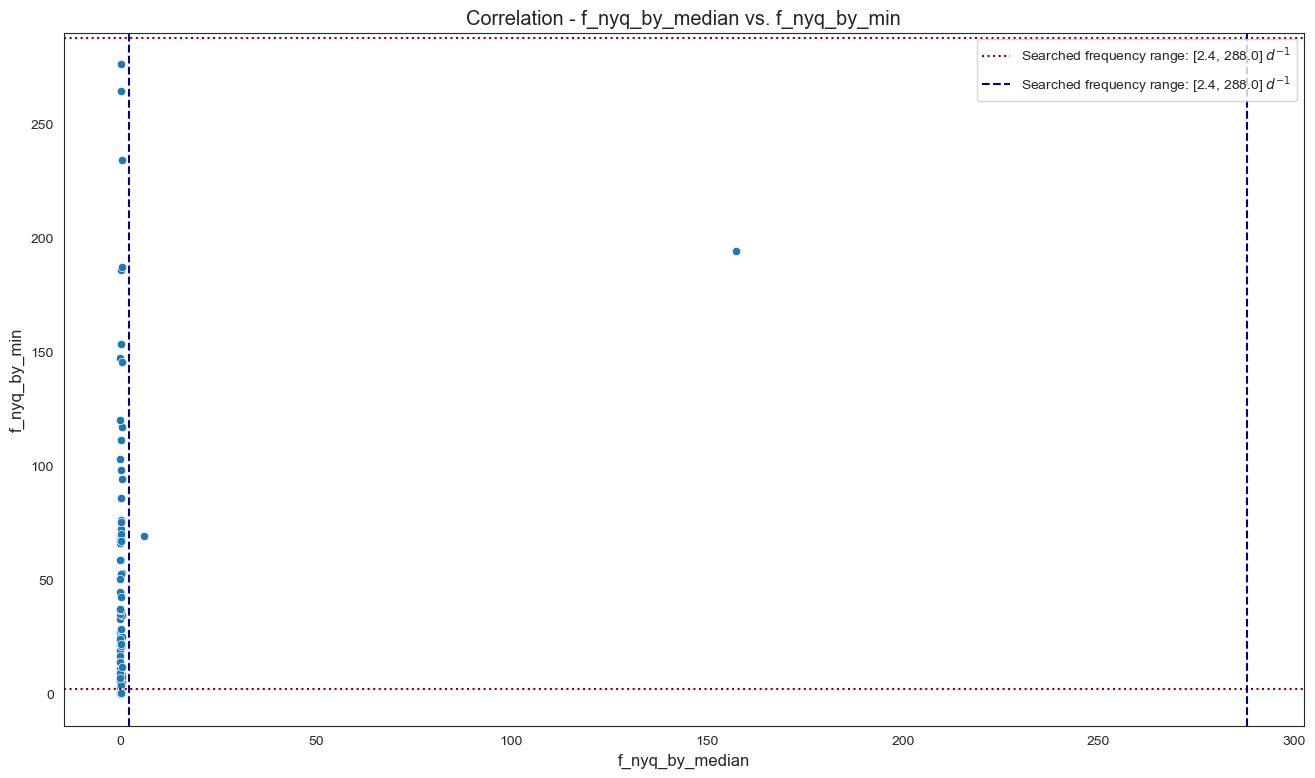

In [20]:
draw_scatter(sampling_df, 'f_nyq_by_median', 'f_nyq_by_min',
             href_lines=[2.4, 288.0], href_label="Searched frequency range: [2.4, 288.0] $d^{-1}$",
             vref_lines=[2.4, 288.0], vref_label="Searched frequency range: [2.4, 288.0] $d^{-1}$")

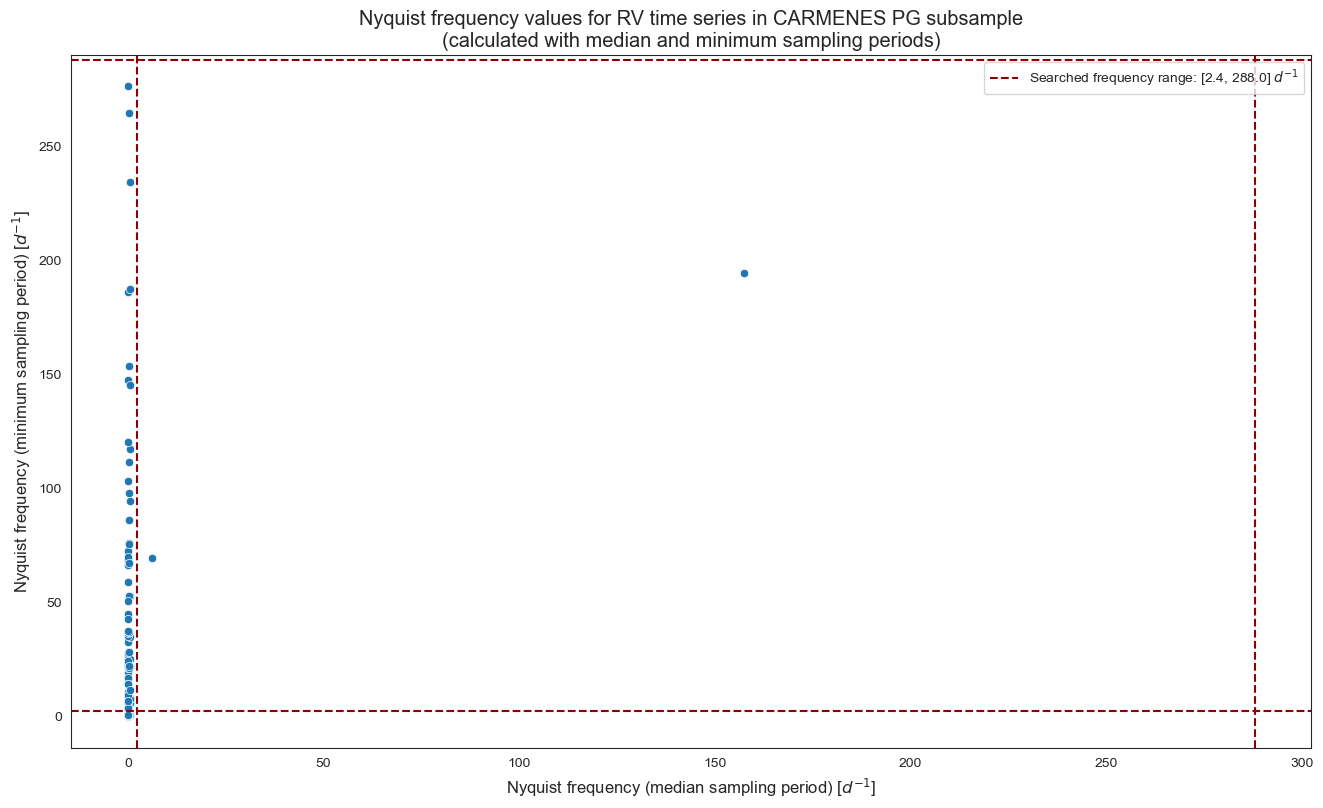

In [21]:
draw_scatter(sampling_df, 'f_nyq_by_median', 'f_nyq_by_min',
             href_lines=[2.4, 288.0], href_label="Searched frequency range: [2.4, 288.0] $d^{-1}$",
             href_color='darkred', href_style='--',
             vref_lines=[2.4, 288.0], vref_label=None,
             vref_color='darkred', vref_style='--',
             title_override="Nyquist frequency values for RV time series in CARMENES PG subsample\n"
                 "(calculated with median and minimum sampling periods)",
             xlabel_override="Nyquist frequency (median sampling period) [$d^{-1}$]",
             ylabel_override="Nyquist frequency (minimum sampling period) [$d^{-1}$]",
             fig_filename=IMAGE_FOLDER + "ETL_22_01_PG_RV_NyquistFrequencies.jpg")


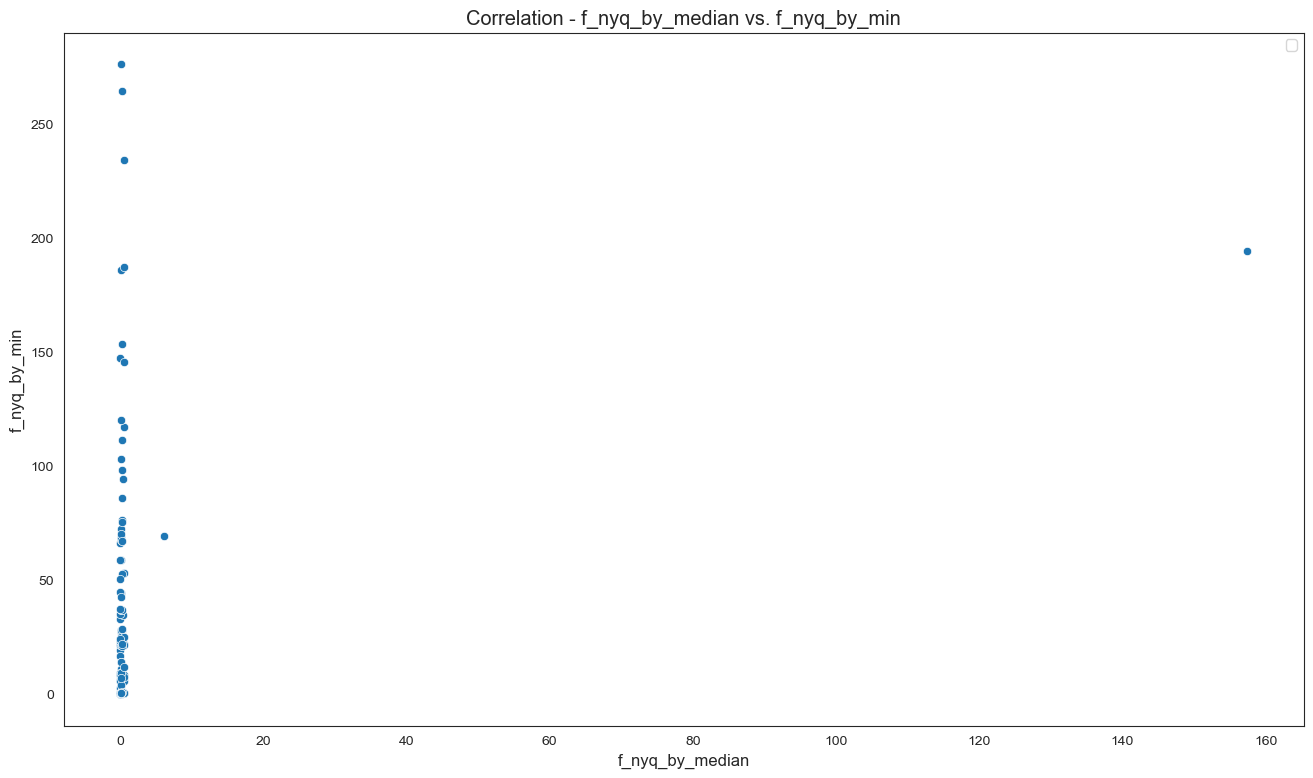

In [22]:
draw_scatter(sampling_df, 'f_nyq_by_median', 'f_nyq_by_min')

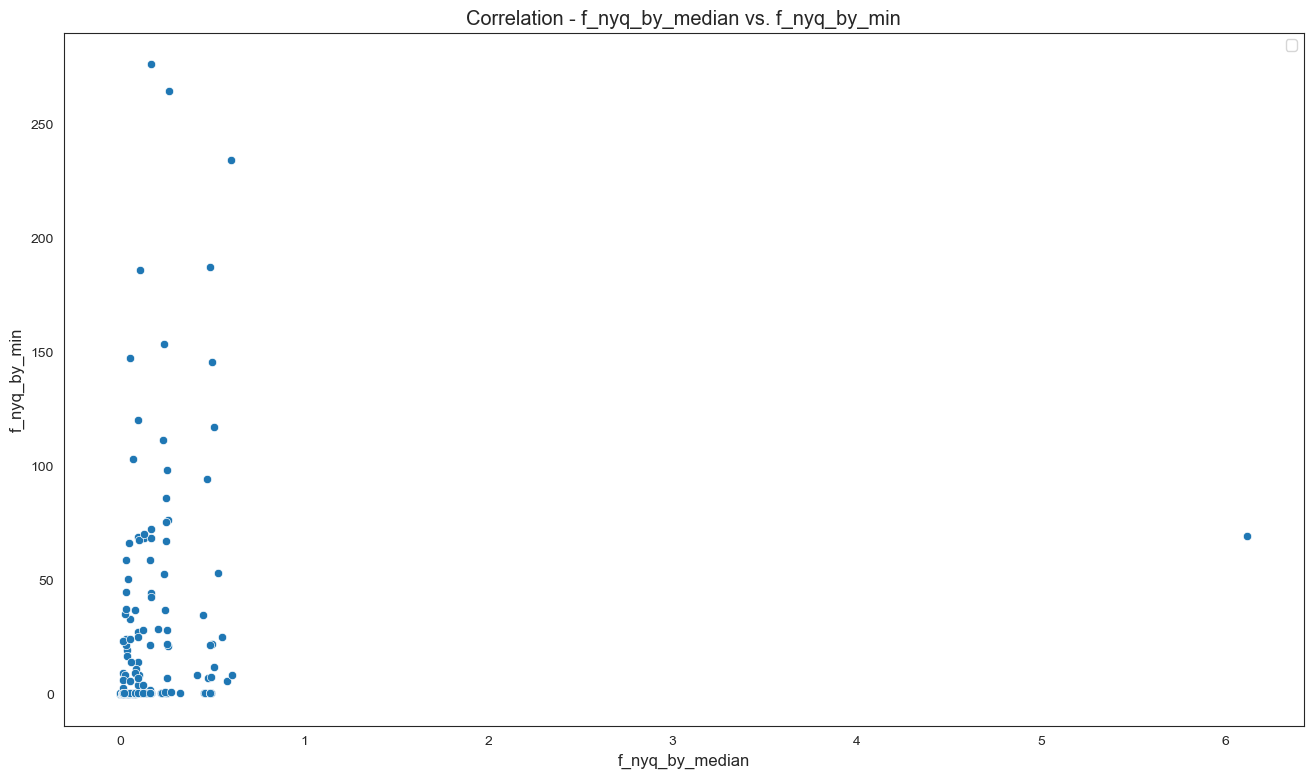

In [23]:
draw_scatter(sampling_df[sampling_df['f_nyq_by_median'] < 15.0], 'f_nyq_by_median', 'f_nyq_by_min')

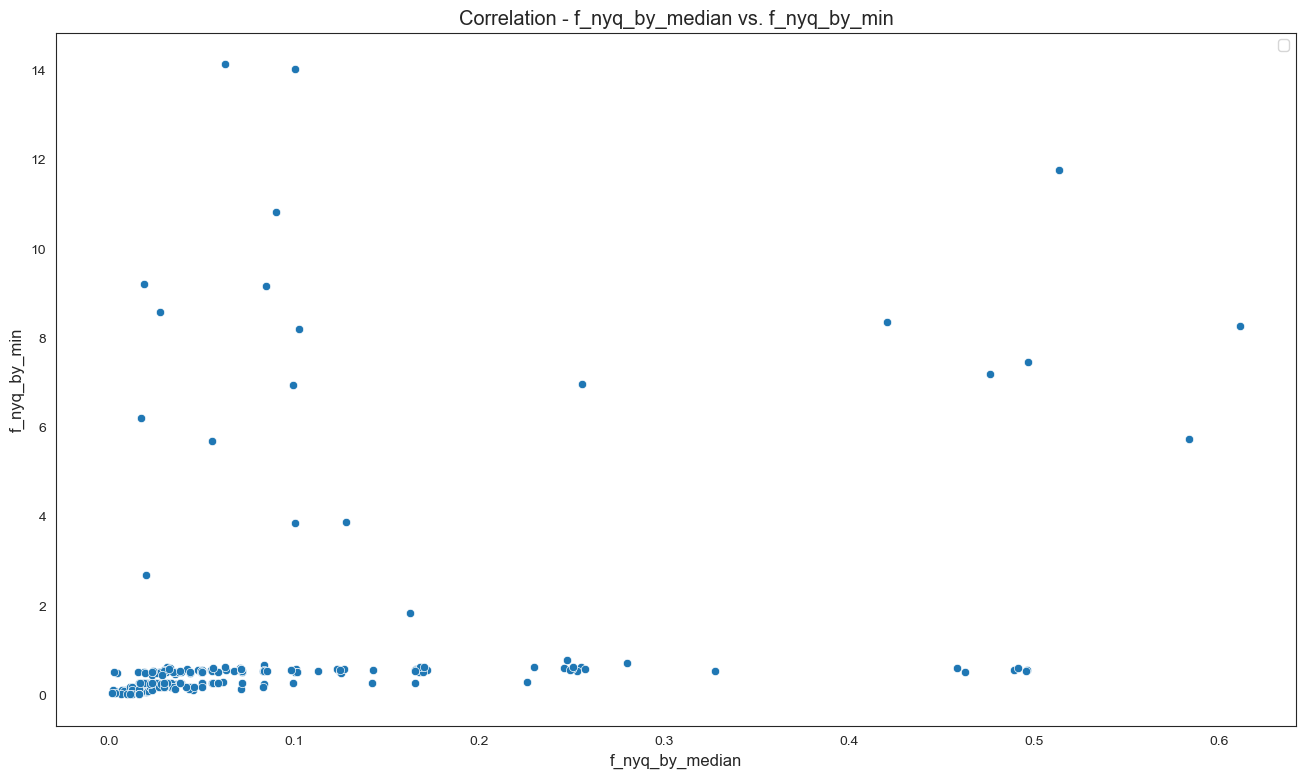

In [24]:
draw_scatter(sampling_df[(sampling_df['f_nyq_by_median'] < 15.0) &
                         (sampling_df['f_nyq_by_min'] < 15.0)],
             'f_nyq_by_median', 'f_nyq_by_min')

#### Distributions of Nyquist frequencies

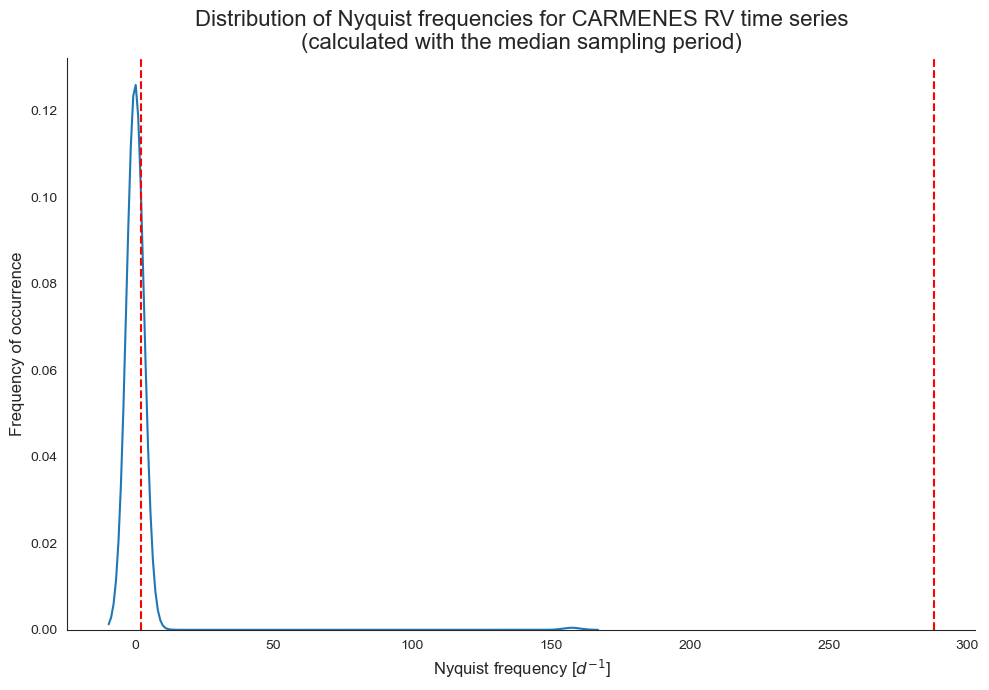

In [28]:
data = sampling_df
x = 'f_nyq_by_median'
freq_range_interest = (2.4, 288.0)
fig_filename = IMAGE_FOLDER + "ETL_22_02_PG_RV_NyquistFrequenciesMedian_Dist.jpg"
g = sns.displot(
    data=data, x=x,
    kind='kde')
ax1 = g.axes[0][0]
ax1.set_xlabel("Nyquist frequency [$d^{-1}$]", fontsize=12)
ax1.set_ylabel("Frequency of occurrence", fontsize=12)
ax1.axvline(x=freq_range_interest[0], color='red', ls='--')
ax1.axvline(x=freq_range_interest[1], color='red', ls='--')
ax1.set_title("Distribution of Nyquist frequencies for CARMENES RV time series\n" \
              "(calculated with the median sampling period)",
              fontsize=16)
g.fig.set_size_inches(10, 7)
plt.tight_layout()
plt.plot();
if fig_filename is None:
    pass
else:
    plt.savefig(fig_filename, format='jpg')

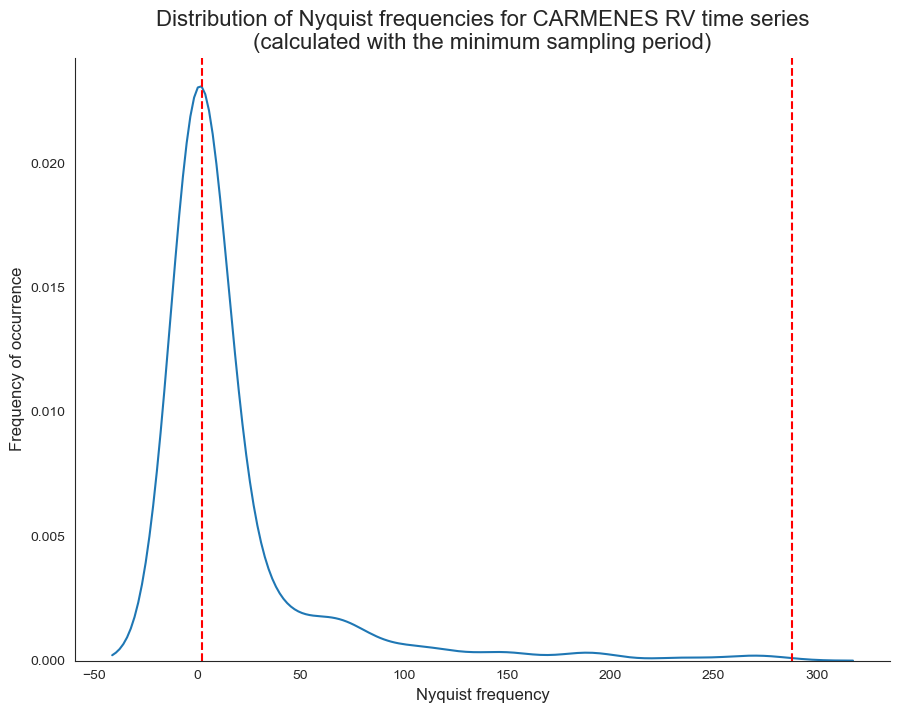

In [70]:
data = sampling_df
x = 'f_nyq_by_min'
freq_range_interest = (2.4, 288.0)
fig_filename = IMAGE_FOLDER + "ETL_22_03_PG_RV_NyquistFrequenciesMin_Dist.jpg"
g = sns.displot(
    data=data, x=x,
    kind='kde')
ax1 = g.axes[0][0]
ax1.set_xlabel("Nyquist frequency", fontsize=12)
ax1.set_ylabel("Frequency of occurrence", fontsize=12)
ax1.axvline(x=freq_range_interest[0], color='red', ls='--')
ax1.axvline(x=freq_range_interest[1], color='red', ls='--')
ax1.set_title("Distribution of Nyquist frequencies for CARMENES RV time series\n" \
              "(calculated with the minimum sampling period)",
              fontsize=16)
g.fig.set_size_inches(10, 7)
plt.plot();
if fig_filename is None:
    pass
else:
    plt.savefig(fig_filename, format='jpg')

## Summary

**OBSERVATIONS AND CONCLUSIONS:**
- For the RV periodogram calculations, we will set:
  - A lower frequency of $2.4\;d^{-1}$.
  - An upper frequency of $288.0\;d^{-1}$.
  - A grid spacing of $0.00008\;d^{-1}$. This would yield a total of 3570000 frequency points to calculate for each periodogram.
- We have also seen that working with periodograms will give trouble in these cases due to the Nyquist frequency limit being below the range of frequencies of interest for our purposes, for most of the objects in the sample.